# Preconditioners

## Packages

In [1]:
import torch
import gpytorch
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import os
import gpboost as gpb
import requests
import pandas as pd
import time

/usr/sepp1.5.1/scratch/tmp/365/FP_data/FSAVecchia/FSVA_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Flag for toy example
toy = True

## Data

In [3]:
# URL of the raw CSV file on GitHub
url = 'https://raw.githubusercontent.com/TimGyger/FSVA/refs/heads/main/Simulation/simulated_data_non_Gaussian_5_prediction.txt'

# Load the CSV file directly from the URL
df = pd.read_csv(url)

# Select the first 5 columns for X
X = df.iloc[:, :5]  # First 5 columns

# Select the last column for y
y = df.iloc[:, 5]  # Last column

# Convert to numpy:
X_np = X.to_numpy()
y_np = y.to_numpy()

if toy:
    X_train = X_np[1:5000,:]
    y_train = y_np[1:5000]
    X_test = X_np[5001:10000,:]
    y_test = y_np[5001:10000]
else:
    X_train = X_np[0:10000,:]
    y_train = y_np[0:10000]
    X_test = X_np[10000:200000,:]
    y_test = y_np[10000:200000]

## Predictive Distribution

### Cholesky

In [4]:
model_fsva = gpb.GPModel(gp_coords=X_train, cov_function="gaussian_ard", 
                         likelihood="bernoulli_logit",num_neighbors = 30,num_ind_points = 200,ind_points_selection = "kmeans++",
                         matrix_inversion_method = "cholesky", gp_approx="full_scale_vecchia",seed = 2)

start_time = time.time()
pred_Chol = model_fsva.predict(gp_coords_pred=X_train, y = y_train, 
                               predict_var=True, cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]))
runtime_Chol = time.time() - start_time

[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Test11
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Start neighbour search re
[GPBoost] [Info] start
[GPBoost] [Info] kNN time until = 0.038793 
[GPBoost] [Info] End neighbour search re
[GPBoost] [Info] FindModePostRandEffCalcMLLFSAVecchia: finished after 3 iterations 


### Iterative

In [5]:
# Different number of sample vectors
vector_sample = [50,100,200,500,1000,2000]
# Number of repetitions
num_rep = 100
if toy:
    num_rep = 10
    vector_sample = [100,200]
# Zero matrices
matrix_SBPV_FITC = np.zeros((len(vector_sample), num_rep))
matrix_SBPV_FITC_t = np.zeros((len(vector_sample), num_rep))
matrix_SBPV_FSVADU = np.zeros((len(vector_sample), num_rep))
matrix_SBPV_FSVADU_t = np.zeros((len(vector_sample), num_rep))
matrix_SPV_FITC = np.zeros((len(vector_sample), num_rep))
matrix_SPV_FITC_t = np.zeros((len(vector_sample), num_rep))
matrix_SPV_FSVADU = np.zeros((len(vector_sample), num_rep))
matrix_SPV_FSVADU_t = np.zeros((len(vector_sample), num_rep))
# Nested loop to iterate over both vectors
for i, val1 in enumerate(vector_sample):
    for j in range(0, num_rep):
        print(i)
        print(j)
        
        # FSVecchia with euclidean-based neighbor search
        model_fsva = gpb.GPModel(gp_coords=X_train, cov_function="gaussian_ard", 
                                 likelihood="bernoulli_logit",num_neighbors = 30,num_ind_points = 200,ind_points_selection = "kmeans++",
                                 matrix_inversion_method = "iterative", gp_approx="full_scale_vecchia",seed = 3)
        model_fsva.set_optim_params(params={"cg_preconditioner_type": "predictive_process_plus_diagonal",
                                            "piv_chol_rank": 200, "seed_rand_vec_trace": j+1})
        model_fsva.set_prediction_data(nsim_var_pred = val1)
        # Start the timer
        start_time = time.time()
        pred_it = model_fsva.predict(gp_coords_pred=X_train, y = y_train, 
                               predict_var=True, cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]))
        # End the timer
        end_time = time.time()
        matrix_SBPV_FITC[i, j] = np.sqrt(np.mean(np.square(pred_Chol['var'] - pred_it['var'])))
        # Calculate elapsed time in seconds
        matrix_SBPV_FITC_t[i, j] = end_time - start_time
        print(matrix_SBPV_FITC)
        
        # FSVecchia with euclidean-based neighbor search
        model_fsva = gpb.GPModel(gp_coords=X_train, cov_function="gaussian_ard", 
                                 likelihood="bernoulli_logit",num_neighbors = 30,num_ind_points = 200,ind_points_selection = "kmeans++",
                                 matrix_inversion_method = "iterative", gp_approx="full_scale_vecchia",seed = 2)
        model_fsva.set_optim_params(params={"cg_preconditioner_type": "predictive_process_plus_diagonal",
                                            "piv_chol_rank": 200, "seed_rand_vec_trace": j+1})
        model_fsva.set_prediction_data(nsim_var_pred = val1)
        # Start the timer
        start_time = time.time()
        pred_it = model_fsva.predict(gp_coords_pred=X_train, y = y_train, 
                               predict_var=True, cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]))
        # End the timer
        end_time = time.time()
        matrix_SPV_FITC[i, j] = np.sqrt(np.mean(np.square(pred_Chol['var'] - pred_it['var'])))
        # Calculate elapsed time in seconds
        matrix_SPV_FITC_t[i, j] = end_time - start_time
        
        

0
0
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Test11
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Start neighbour search re
[GPBoost] [Info] start
[GPBoost] [Info] kNN time until = 0.017467 
[GPBoost] [Info] End neighbour search re
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] FindModePostRandEffCalcMLLFSAVecchia: finished after 3 iterations 
[GPBoost] [Info] First
[[0.00029441 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]]
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Test11
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Start neighbour search re
[GPBoost] [Info] start
[GPBoost] 

[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] FindModePostRandEffCalcMLLFSAVecchia: finished after 3 iterations 
[GPBoost] [Info] First
[[0.00029441 0.00027623 0.00028245 0.00026428 0.00029083 0.00028293
  0.00027894 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]]
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Test11
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Start neighbour search re
[GPBoost] [Info] start
[GPBoost] [Info] kNN time until = 0.01516 
[GPBoost] [Info] End neighbour search re
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] FindModePostRandEffCalcMLLFSAVecchia: finished after 3 iterations 
[GPBoost] [Info] First
0
7
[GPBoost] [Info] Starting kmeans++ algorithm for determining ind

[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Start neighbour search re
[GPBoost] [Info] start
[GPBoost] [Info] kNN time until = 0.013718 
[GPBoost] [Info] End neighbour search re
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] FindModePostRandEffCalcMLLFSAVecchia: finished after 3 iterations 
[GPBoost] [Info] First
1
3
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Test11
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Start neighbour search re
[GPBoost] [Info] start
[GPBoost] [Info] kNN time until = 0.017561 
[GPBoost] [Info] End neighbour search re
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] FindModePostRandEffCalcMLLFSAVecchia: finished after 3 iterations 
[GPBoost] [Info] First
[[

[GPBoost] [Info] FindModePostRandEffCalcMLLFSAVecchia: finished after 3 iterations 
[GPBoost] [Info] First
1
9
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Test11
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Start neighbour search re
[GPBoost] [Info] start
[GPBoost] [Info] kNN time until = 0.091733 
[GPBoost] [Info] End neighbour search re
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] FindModePostRandEffCalcMLLFSAVecchia: finished after 3 iterations 
[GPBoost] [Info] First
[[0.00029441 0.00027623 0.00028245 0.00026428 0.00029083 0.00028293
  0.00027894 0.00026942 0.00029055 0.00027731]
 [0.000215   0.00020848 0.0001896  0.00019771 0.00020962 0.00020656
  0.00019686 0.00020584 0.00020472 0.00019019]]
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Test11
[GPBoost

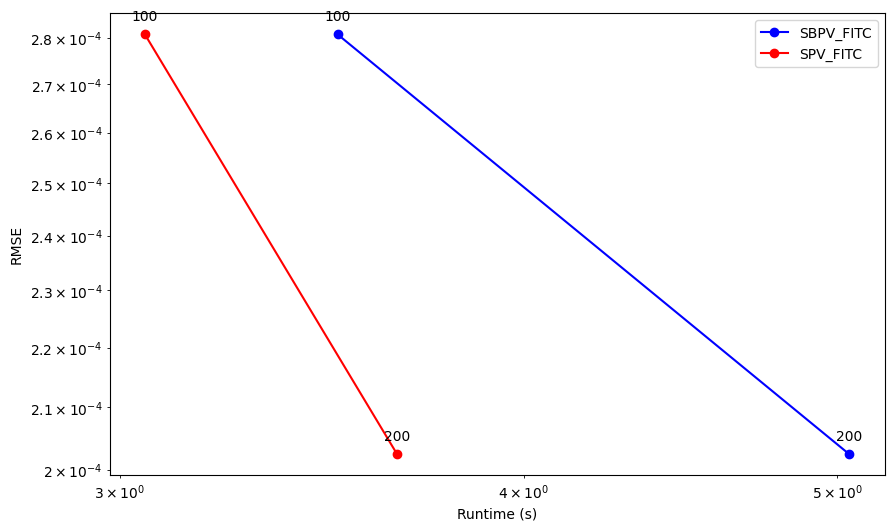

In [6]:
# Plotting the data
fig, ax = plt.subplots(figsize=(10, 6))

# Function to plot lines with points and annotations
def plot_matrix_data(matrix_data, matrix_time, label, color):
    mean_vals = np.mean(matrix_data, axis=1)
    mean_times = np.mean(matrix_time, axis=1)
    ax.plot(mean_times, mean_vals, label=label, color=color, marker='o')

    # Annotate the points with the vector_sample values
    for i, (x, y) in enumerate(zip(mean_times, mean_vals)):
        ax.annotate(f'{vector_sample[i]}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

# Plot for SBPV_FITC
plot_matrix_data(matrix_SBPV_FITC, matrix_SBPV_FITC_t, 'SBPV_FITC', 'b')

# Plot for SPV_FITC
plot_matrix_data(matrix_SPV_FITC, matrix_SPV_FITC_t, 'SPV_FITC', 'r')


# Set plot properties
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Runtime (s)')
ax.set_ylabel('RMSE')
ax.legend()

# Show plot
plt.show()